In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import set_random_seed

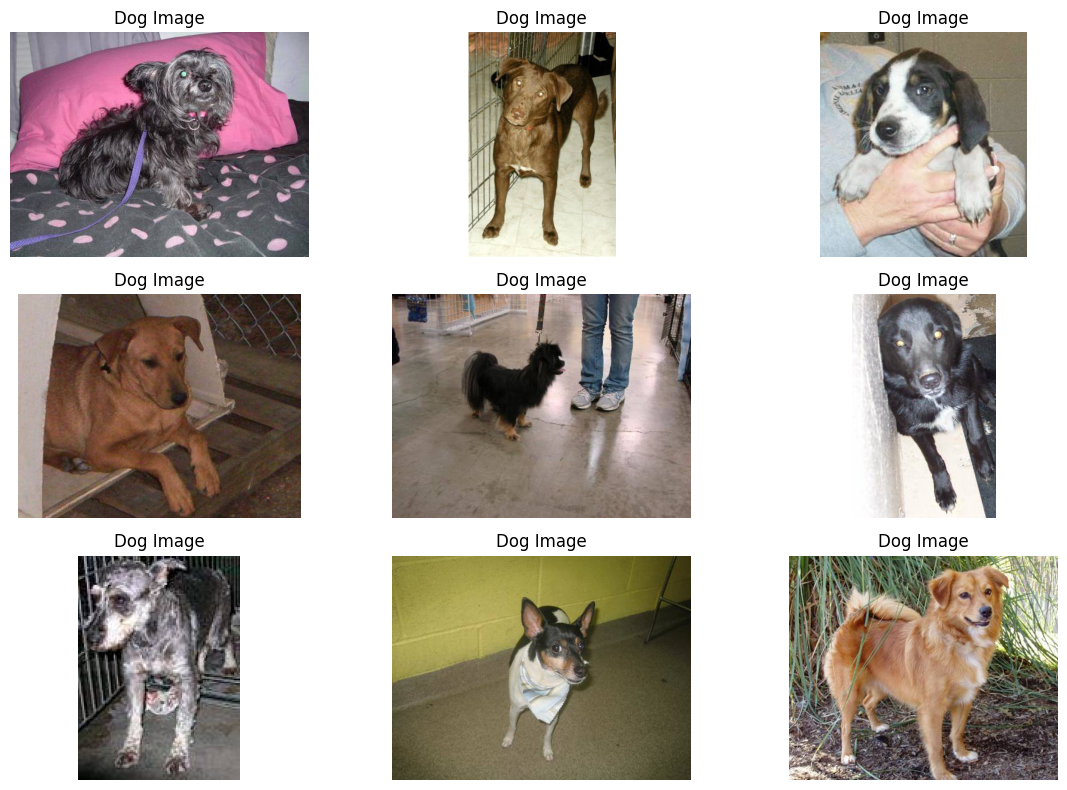

In [2]:


data_dir = "train"


dog_subfolder = os.path.join(data_dir, "dog")


dog_image_files = os.listdir(dog_subfolder)


dog_images = []
for i in range(9):
    img_path = os.path.join(dog_subfolder, dog_image_files[i])
    img = image.load_img(img_path) 
    img_array = image.img_to_array(img)
    img_array /= 255.0  
    dog_images.append(img_array)


plt.figure(figsize=(12, 8))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(dog_images[i])
    plt.title('Dog Image')
    plt.axis('off')


plt.tight_layout()


plt.show()

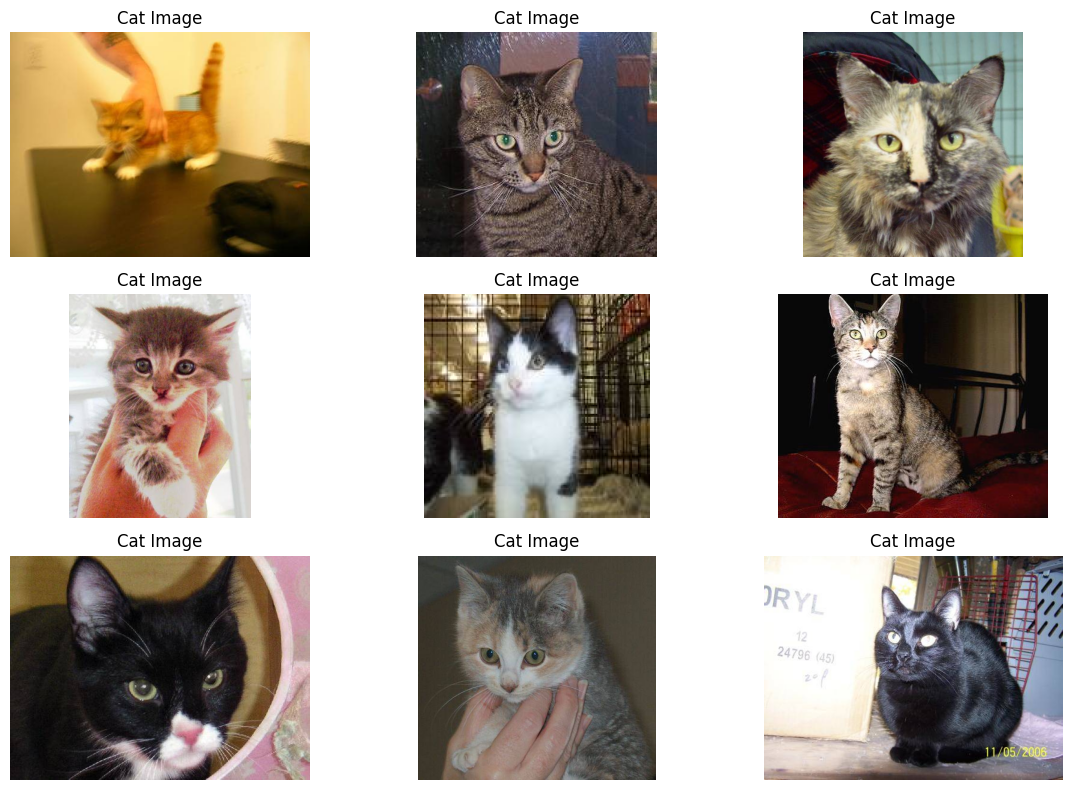

In [3]:

data_dir = "train"


cats_subfolder = os.path.join(data_dir, "cat")


cats_image_files = os.listdir(cats_subfolder)


cats_images = []
for i in range(min(9, len(cats_image_files))):  
    img_path = os.path.join(cats_subfolder, cats_image_files[i])
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    img_array /= 255.0
    cats_images.append(img_array)


plt.figure(figsize=(12, 8))

for i in range(len(cats_images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cats_images[i])
    plt.title('Cat Image')
    plt.axis('off')


plt.tight_layout()


plt.show()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = "train"
image_size = (200, 200)

datagentrain = ImageDataGenerator()
datagentest = ImageDataGenerator()

train_data = datagentrain.flow_from_directory(
    train_dir,
    target_size = image_size,
    classes = ["dog", "cat"] 
)

test_data = datagentest.flow_from_directory(
    train_dir,
    target_size = image_size,
    classes = ["test"] 
)

Found 24999 images belonging to 2 classes.
Found 0 images belonging to 1 classes.


In [5]:

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

model = Sequential()
model.add(Conv2D(input_shape = (224,224,3), filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2),strides = (2,2)))


model.add(Flatten())
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 4096,activation = "relu"))
model.add(Dense(units = 2, activation = "softmax"))

c:\Users\Felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:

from keras.optimizers import Adam


model.compile(loss = keras.losses.categorical_crossentropy, optimizer = Adam(learning_rate = 0.001), metrics = ["accuracy"])

In [13]:
model.fit(train_data, epochs = 1)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 25088, but received input with shape (None, 18432)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 200, 200, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("models/vgg16_1.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True, save_weights_only = False, mode = "auto")
early = EarlyStopping(monitor = "val_accuracy", patience = 3, verbose = 1, mode = "auto")
hist = model.fit(train_data, steps_per_epoch = 100, validation_data = test_data, validation_steps = 10, epochs = 3, callbacks = [checkpoint, early])

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=../models/vgg16_1.h5

In [ ]:

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])


plt.show()

NameError: name 'hist' is not defined

In [1]:
from keras.preprocessing import image
from keras.models import load_model

img = image.load_img("test/9.jpg", target_size = (200, 200))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis = 0)
saved_model = load_model("models/vgg16_1.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("cat")
else:
    print("dog")

FileNotFoundError: [Errno 2] No such file or directory: 'test/9.jpg'